In [0]:
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from random import shuffle
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train_file = "/content/drive/My Drive/train.zip"
test_file = "/content/drive/My Drive/test.zip"

In [0]:
import zipfile
with zipfile.ZipFile(train_file, 'r') as z:
  z.extractall()
with zipfile.ZipFile(test_file, 'r') as z:
  z.extractall()

In [10]:
ls

drive/  sample_data/  test/  train/


In [0]:
TEST_DIR="./test/"
TRAIN_DIR="./train/"
LEARNING_RATE= 1e-3
MODEL_NAME = "dogsvscats-{}-{}.model".format(LEARNING_RATE, "6conv-fire")
IMG_SIZE=50

In [0]:
def label_img(img): 
    img_name = img.split('.')[-3] 
    if img_name == 'cat': return [1, 0] 
    elif img_name == 'dog': return [0, 1] 

In [0]:
def create_train_data(): 
    training_data = [] 
    for img in tqdm(os.listdir(TRAIN_DIR)): 
        label = label_img(img) 
        path = os.path.join(TRAIN_DIR, img) 
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  
        training_data.append([np.array(img), np.array(label)]) 
    shuffle(training_data) 
    np.save('train_data.npy', training_data) 
    return training_data 
  

In [16]:
train_data = create_train_data()

100%|██████████| 25000/25000 [00:27<00:00, 913.96it/s]


In [0]:
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.core import input_data, dropout, fully_connected 
from tflearn.layers.estimator import regression 

In [0]:
import tensorflow as tf
tf.reset_default_graph() 
convnet = input_data(shape =[None, IMG_SIZE, IMG_SIZE, 1], name ='input') 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = fully_connected(convnet, 1024, activation ='relu') 
convnet = dropout(convnet, 0.8) 
  
convnet = fully_connected(convnet, 2, activation ='softmax') 
convnet = regression(convnet, optimizer ='adam', learning_rate = LEARNING_RATE, 
      loss ='categorical_crossentropy', name ='targets') 
  
model = tflearn.DNN(convnet, tensorboard_dir ='log') 

In [0]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
  model.load(MODEL_FRAME)
  print("model loaded!")

In [23]:
train = train_data[:-500] 
test = train_data[-500:] 
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
Y = [i[1] for i in train] 
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
test_y = [i[1] for i in test] 
model.fit({'input': X}, {'targets': Y}, n_epoch = 10,  
    validation_set =({'input': test_x}, {'targets': test_y}),  
    snapshot_step = 500, show_metric = True, run_id = MODEL_NAME) 

Training Step: 3829  | total loss: 0.37396 | time: 161.876s
| Adam | epoch: 010 | loss: 0.37396 - acc: 0.8337 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.36165 | time: 163.296s
| Adam | epoch: 010 | loss: 0.36165 - acc: 0.8394 | val_loss: 0.51778 - val_acc: 0.7820 -- iter: 24500/24500
--


In [25]:
testing_data = []
for img in tqdm(os.listdir("./test/")):
  path = os.path.join("./test/", img)
  img_num = img.split('.')[0]
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  testing_data.append([np.array(img), img_num]) 

100%|██████████| 12500/12500 [00:13<00:00, 946.43it/s]


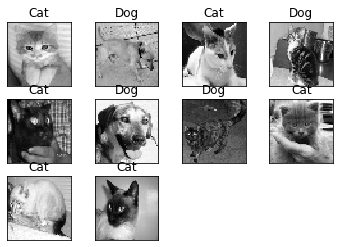

In [26]:
fig = plt.figure() 
  
for num, data in enumerate(testing_data[:10]): 
    # cat: [1, 0] 
    # dog: [0, 1] 
      
    img_num = data[1] 
    img_data = data[0] 
      
    y = fig.add_subplot(3, 4, num + 1) 
    orig = img_data 
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) 
  
    # model_out = model.predict([data])[0] 
    model_out = model.predict([data])[0] 
      
    if np.argmax(model_out) == 1: str_label ='Dog'
    else: str_label ='Cat'
          
    y.imshow(orig, cmap ='gray') 
    plt.title(str_label) 
    y.axes.get_xaxis().set_visible(False) 
    y.axes.get_yaxis().set_visible(False) 
plt.show() 